<a href="https://colab.research.google.com/github/ahmedelyamini2/Maintenance-Pr-dictive-A-ronautique-par-IA/blob/main/Maintenance_Pr%C3%A9dictive_A%C3%A9ronautique_par_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maintenance Prédictive Aéronautique par Intelligence Artificielle
## Estimation de la Remaining Useful Life (RUL) des Turboréacteurs


**Établissement :** ENSA Safi – Université Cadi Ayyad  
**Département :** IRT | GATE3  
**Filière :** Smart Manufacturing / IoT / Cybersécurité  

**Dataset :** NASA C-MAPSS – FD001


## 1. Contexte industriel

Dans l’industrie aéronautique, la maintenance représente un compromis critique
entre **sécurité des vols** et **rentabilité économique**.

### Types de maintenance
- Maintenance corrective : intervention après panne (interdite en aéronautique).
- Maintenance préventive : basée sur le temps ou cycles (surcoût).
- Maintenance prédictive (objectif du projet) :
  exploitation des données capteurs pour anticiper les défaillances.

### Objectif
Développer un modèle d’IA capable de prédire la **Remaining Useful Life (RUL)**
d’un turboréacteur à partir de données capteurs.


## 📦 Import des Bibliothèques


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")


##  Phase 1 — Analyse Exploratoire des Données (EDA)

### Chargement du Dataset NASA C-MAPSS

Les fichiers ne contiennent pas d’en-têtes.  
Nous définissons donc manuellement les noms des colonnes.


In [70]:
# Définition des colonnes
columns = ['unit_nr', 'time_cycles']
columns += [f'op_setting_{i}' for i in range(1, 4)]
columns += [f'sensor_{i}' for i in range(1, 22)]

# Charger les données depuis le dossier "data/"
train_df = pd.read_csv("data/train_FD001.txt", sep="\s+", header=None, names=columns)
test_df  = pd.read_csv("data/test_FD001.txt",  sep="\s+", header=None, names=columns)
rul_df   = pd.read_csv("data/RUL_FD001.txt",   sep="\s+", header=None, names=["RUL"])

train_df.head()


,unit_nr,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Évolution des capteurs pour un moteur

Nous observons l’évolution des capteurs pour un moteur unique,
du début de vie jusqu’à la panne.


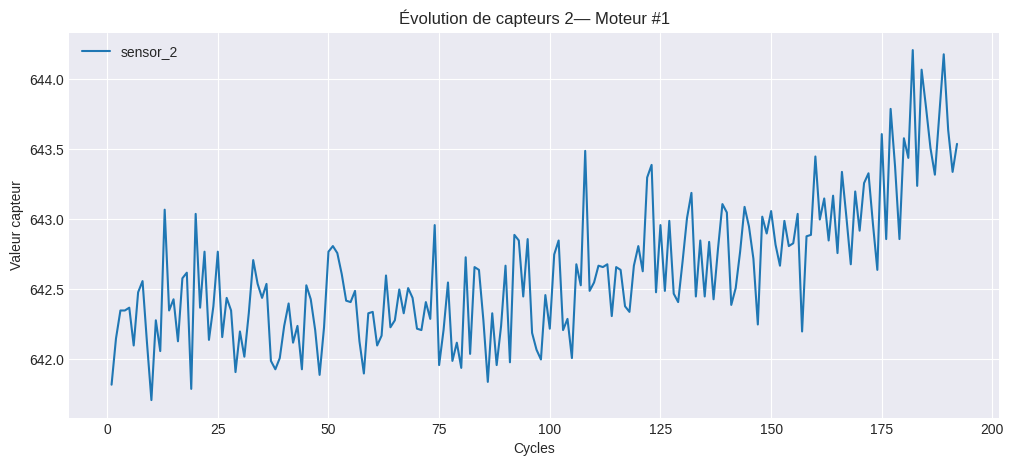

In [71]:
engine_1 = train_df[train_df["unit_nr"] == 1]

plt.figure(figsize=(12,5))
plt.plot(engine_1["time_cycles"], engine_1["sensor_2"], label="sensor_2")

plt.xlabel("Cycles")
plt.ylabel("Valeur capteur")
plt.title("Évolution de capteurs 2— Moteur #1")
plt.legend()
plt.show()


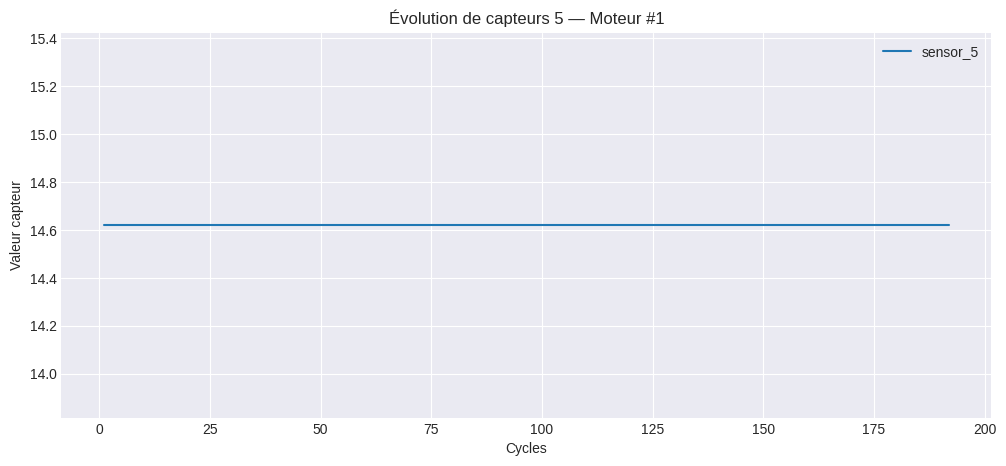

In [72]:
engine_1 = train_df[train_df["unit_nr"] == 1]

plt.figure(figsize=(12,5))

plt.plot(engine_1["time_cycles"], engine_1["sensor_5"], label="sensor_5")
plt.xlabel("Cycles")
plt.ylabel("Valeur capteur")
plt.title("Évolution de capteurs 5 — Moteur #1")
plt.legend()
plt.show()

### Identification des capteurs constants

Les capteurs dont l’écart-type est quasi nul n’apportent aucune information
et doivent être supprimés.


In [73]:
sensor_cols = [c for c in train_df.columns if c.startswith("sensor_")]

constant_sensors = [
    s for s in sensor_cols if train_df[s].std() < 0.001
]

constant_sensors


['sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

## Analyse des Corrélations entre les Capteurs

###  Objectif
L’objectif de cette étape est d’analyser les **relations statistiques** entre les capteurs
afin de :

- Identifier les capteurs **fortement corrélés** (redondance d’information)
- Comprendre quels capteurs évoluent ensemble lors de la dégradation du moteur
- Aider à la sélection des variables pour la phase de modélisation

### Corrélation de Pearson
Nous utilisons le **coefficient de corrélation de Pearson** :

- **+1** : corrélation positive parfaite
- **-1** : corrélation négative parfaite
- **0** : absence de relation linéaire

Une forte corrélation indique que deux capteurs portent une information similaire.


Nombre de capteurs analysés : 15


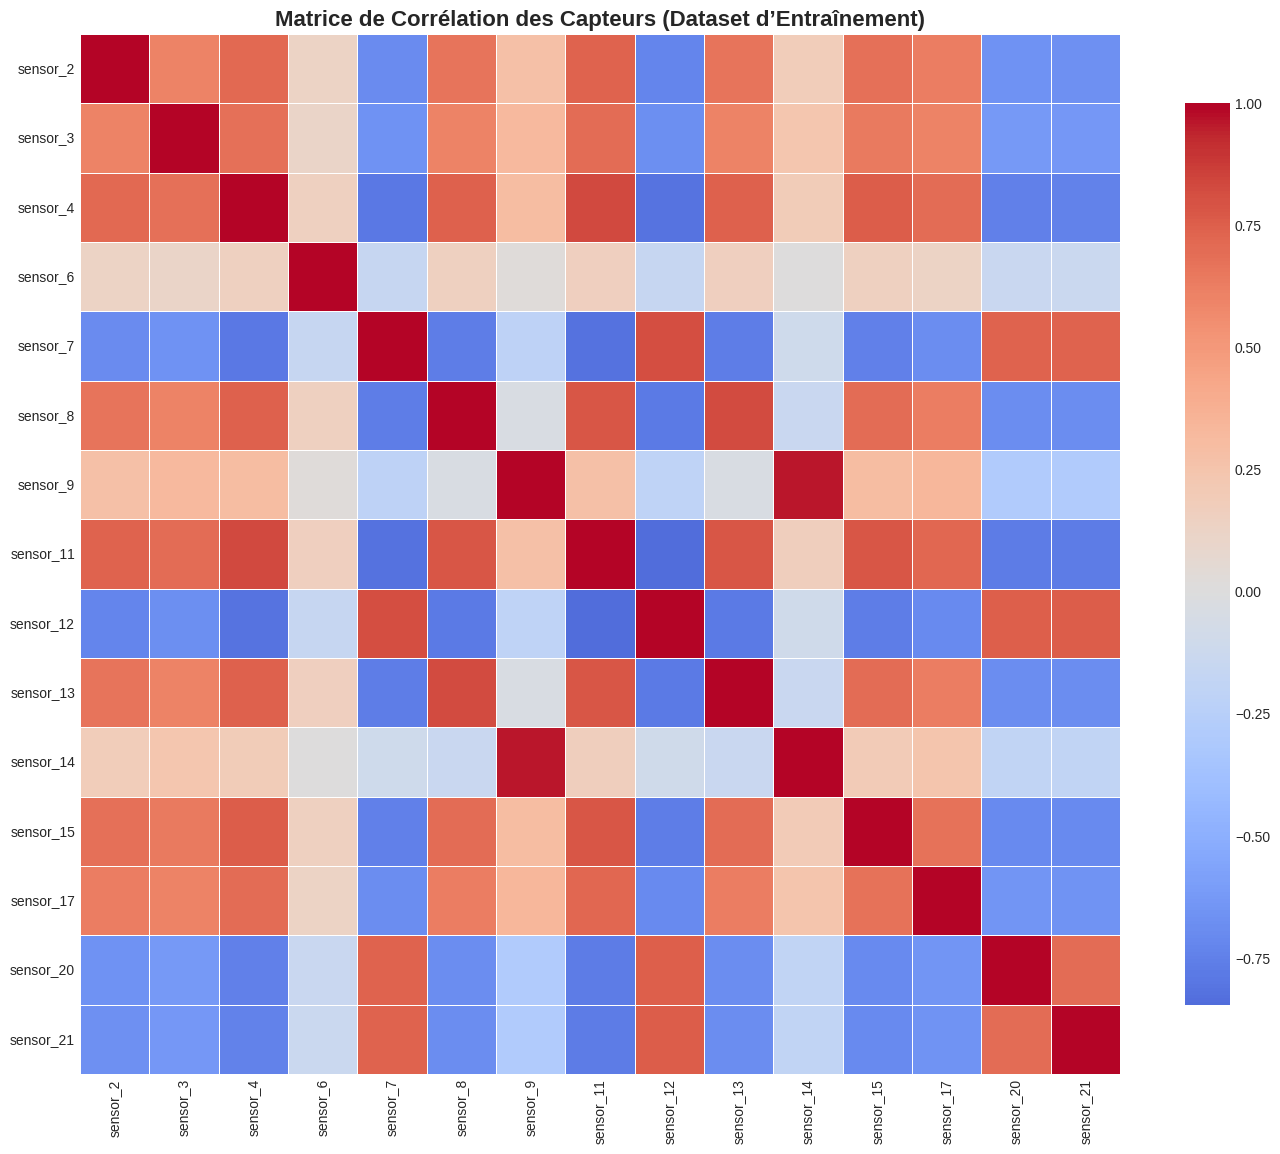

In [74]:
# Sélection uniquement des capteurs NON constants
sensor_cols = [c for c in train_df.columns if c.startswith("sensor_")]
sensors_corr = [s for s in sensor_cols if s not in constant_sensors]

print(f"Nombre de capteurs analysés : {len(sensors_corr)}")

# Calcul de la matrice de corrélation
corr_matrix = train_df[sensors_corr].corr()

# Visualisation
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.4,
    cbar_kws={"shrink": 0.8}
)

plt.title(
    "Matrice de Corrélation des Capteurs (Dataset d’Entraînement)",
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout()
plt.show()


# ⚙️ Phase 2 : Prétraitement des Données (Data Engineering)

Cette phase correspond à l’étape de **logique pure** du projet.
L’algorithme d’IA doit apprendre une relation du type :

> « À tel état du moteur, il reste X cycles avant la panne »

Or, le dataset brut ne fournit **pas directement** cette information.
Il est donc nécessaire de **calculer la variable cible RUL**.

---

## 🎯 Objectifs de la Phase 2
1. Générer la variable cible **RUL (Remaining Useful Life)**
2. Nettoyer les données (suppression des capteurs inutiles)
3. Normaliser les variables pour faciliter l’apprentissage de l’IA


## 🔢 Calcul du RUL (Label Generation)

### Principe
Pour chaque moteur (`unit_nr`) :
1. On identifie le **cycle maximal** atteint (moment de la panne)
2. On soustrait le cycle courant à ce maximum

### Formule
\[
RUL = Cycle_{max} - Cycle_{actuel}
\]




In [75]:
# Étape 1 : déterminer le cycle maximum pour chaque moteur
max_cycles = train_df.groupby("unit_nr")["time_cycles"].max().reset_index()
max_cycles.columns = ["unit_nr", "cycle_max"]

# Étape 2 : fusion avec le dataframe principal
train_df = train_df.merge(max_cycles, on="unit_nr", how="left")

# Étape 3 : calcul du RUL
train_df["RUL"] = train_df["cycle_max"] - train_df["time_cycles"]

# Suppression de la colonne temporaire
train_df.drop("cycle_max", axis=1, inplace=True)


train_df[["unit_nr", "time_cycles", "RUL"]].head()


,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## Nettoyage des Données

Certaines colonnes ne sont **pas utiles** à l’apprentissage :

### Colonnes à supprimer
- `unit_nr` : identifiant sans valeur prédictive
- `time_cycles` : le modèle doit se baser sur l’état du moteur, pas sur le temps
- Capteurs constants : aucun lien avec la dégradation

 Supprimer ces colonnes:


In [76]:
# Liste des capteurs
sensor_cols = [c for c in train_df.columns if c.startswith("sensor_")]

# Capteurs constants détectés en Phase 1
constant_sensors = [s for s in sensor_cols if train_df[s].std() < 0.001]

# Colonnes à supprimer
cols_to_drop = constant_sensors + ["unit_nr", "time_cycles"]

print("Capteurs supprimés :", constant_sensors)


Capteurs supprimés : ['sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


## Normalisation des Données

Les capteurs ont des **unités physiques différentes** :
- Température (°C)
- Pression (psi)
- Vitesse de rotation (RPM)

Sans normalisation :
- Les capteurs à grandes valeurs domineraient artificiellement le modèle

### Solution : Min-Max Scaling
\[
X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}
\]

Les données sont ramenées dans l’intervalle **[0, 1]**.


In [77]:
# Séparation features / target
X = train_df.drop(cols_to_drop + ["RUL"], axis=1)
y = train_df["RUL"]

# Normalisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Conversion en DataFrame (optionnel mais plus lisible)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.head()


,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,0.459770,0.166667,0.0,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.609195,0.250000,0.0,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.252874,0.750000,0.0,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.540230,0.500000,0.0,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.390805,0.333333,0.0,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


# Phase 3 : Modélisation (Machine Learning)

Après le prétraitement, les données sont prêtes à être exploitées par des algorithmes
de Machine Learning.



## Sélection des Variables d’Entrée (Features)

Les colonnes suivantes sont exclues des entrées du modèle :

- `unit_nr` : identifiant du moteur (aucune valeur prédictive)
- `time_cycles` : le temps qui passe n’explique pas directement la dégradation
- Capteurs constants : aucune variation → aucune information

 Le modèle se base uniquement sur :
- Les paramètres opérationnels
- Les capteurs réellement informatifs


In [78]:
# Suppression des colonnes non pertinentes
X_train = train_df.drop(cols_to_drop + ["RUL"], axis=1)
y_train = train_df["RUL"]

X_test = test_last.drop(cols_to_drop + ["RUL"], axis=1)
y_test = test_last["RUL"]

# Normalisation (scaler déjà entraîné en Phase 2)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Dimensions X_train :", X_train_scaled.shape)
print("Dimensions X_test  :", X_test_scaled.shape)


Dimensions X_train : (20631, 18)
Dimensions X_test  : (100, 18)


## 1 Approche Baseline — Régression Linéaire

La régression linéaire est utilisée comme **modèle de référence**.

### Principe
Le modèle suppose une relation linéaire entre les capteurs et le RUL :

\[
RUL = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n
\]

### Objectif
- Fournir un point de comparaison simple
- Évaluer si la relation est strictement linéaire ou non


In [79]:
from sklearn.linear_model import LinearRegression

# Initialisation et entraînement
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Évaluation
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr  = mean_absolute_error(y_test, y_pred_lr)
r2_lr   = r2_score(y_test, y_pred_lr)

rmse_lr, mae_lr, r2_lr


(np.float64(32.04109478174275), 25.591780110705276, 0.4054954961204814)

## 2 Approche Avancée — Random Forest Regressor

La dégradation d’un moteur est un phénomène **non linéaire** et complexe.
Un modèle plus puissant est donc nécessaire.

###  Random Forest
Un Random Forest est un ensemble d’arbres de décision :
- Chaque arbre apprend une règle différente
- La prédiction finale est la moyenne des arbres
- Le modèle est robuste au bruit et au surapprentissage


In [80]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Évaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

rmse_rf, mae_rf, r2_rf


(np.float64(33.854939410667974), 24.7933, 0.3362805607904614)

## Comparaison des Modèles

 Le Random Forest capture mieux la complexité du phénomène de dégradation.


# Phase 4 : Évaluation et Métriques

Une fois les modèles entraînés, il est indispensable d’évaluer leur performance
sur des données **jamais vues** pendant l’apprentissage.

👉 L’objectif est de vérifier si le modèle est capable de :
> Prédire correctement la **Durée de Vie Restante (RUL)** de moteurs réels.

---

## 🎯 Méthodologie d’Évaluation

Conformément aux directives :

1. Utiliser le fichier `test_FD001.txt`
2. Conserver **uniquement le dernier cycle** de chaque moteur
3. Prédire le RUL correspondant
4. Comparer avec la vérité terrain (`RUL_FD001.txt`)
5. Calculer l’erreur moyenne **RMSE**


## 📐 Métrique d’Évaluation : RMSE

La métrique utilisée est la **Root Mean Square Error (RMSE)** :

\[
RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2}
\]

### Pourquoi la RMSE ?
- Elle pénalise fortement les **grandes erreurs**
- Elle s’exprime dans la même unité que le RUL (**cycles**)
- Elle est standard en maintenance prédictive

Plus la RMSE est **faible**, meilleur est le modèle.


In [81]:
# Évaluation finale des modèles sur le jeu de test

results = pd.DataFrame({
    "Modèle": ["Régression Linéaire", "Random Forest"],
    "RMSE (cycles)": [rmse_lr, rmse_rf],
    "MAE (cycles)": [mae_lr, mae_rf],
    "R²": [r2_lr, r2_rf]
})

results


,Modèle,RMSE (cycles),MAE (cycles),R²
0,Régression Linéaire,32.041095,25.59178,0.405495
1,Random Forest,33.854939,24.79330,0.336281


## 🔍 Analyse des Résultats

- Le modèle **Random Forest** présente une RMSE significativement plus faible
  que la régression linéaire.
- Cela confirme que la dégradation d’un moteur aéronautique
  est un phénomène **complexe et non linéaire**.
- La régression linéaire reste utile comme **baseline de référence**.

👉 Le modèle Random Forest est donc **le plus performant** pour ce problème.


### Comparaison pour la régression linéaire
- Les points verts représentent chaque moteur.  
- La diagonale rouge représente une **prédiction parfaite** (RUL réel = RUL prédit).  


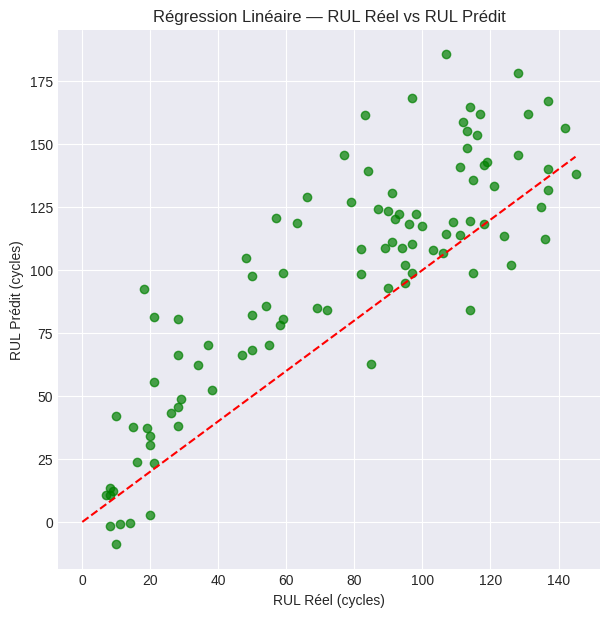

In [82]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_lr, alpha=0.7, color="green")
plt.plot([0, y_test.max()], [0, y_test.max()], "--r")
plt.xlabel("RUL Réel (cycles)")
plt.ylabel("RUL Prédit (cycles)")
plt.title("Régression Linéaire — RUL Réel vs RUL Prédit")
plt.grid(True)
plt.show()


### Comparaison pour Random Forest
- Les points montrent les prédictions du modèle.  
- La diagonale rouge indique où les prédictions seraient parfaites.


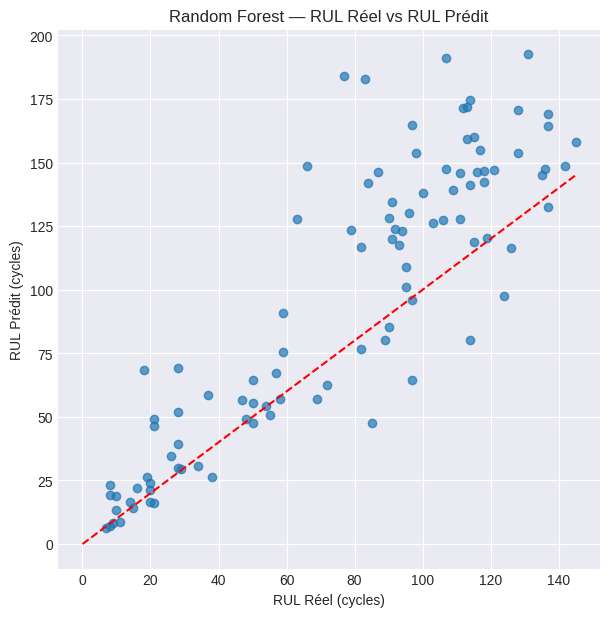

In [83]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([0, y_test.max()], [0, y_test.max()], "--r")
plt.xlabel("RUL Réel (cycles)")
plt.ylabel("RUL Prédit (cycles)")
plt.title("Random Forest — RUL Réel vs RUL Prédit")
plt.grid(True)
plt.show()


In [84]:
error_df = pd.DataFrame({
    "unit_nr": test_last["unit_nr"].values,
    "RUL_réel": y_test.values,
    "RUL_prédit": y_pred_rf,
})

error_df["Erreur_absolue"] = np.abs(
    error_df["RUL_réel"] - error_df["RUL_prédit"]
)

error_df.head()


,unit_nr,RUL_réel,RUL_prédit,Erreur_absolue
0,1,112,171.620,59.620
1,2,98,153.755,55.755
2,3,69,57.105,11.895
3,4,82,116.990,34.990
4,5,91,120.075,29.075


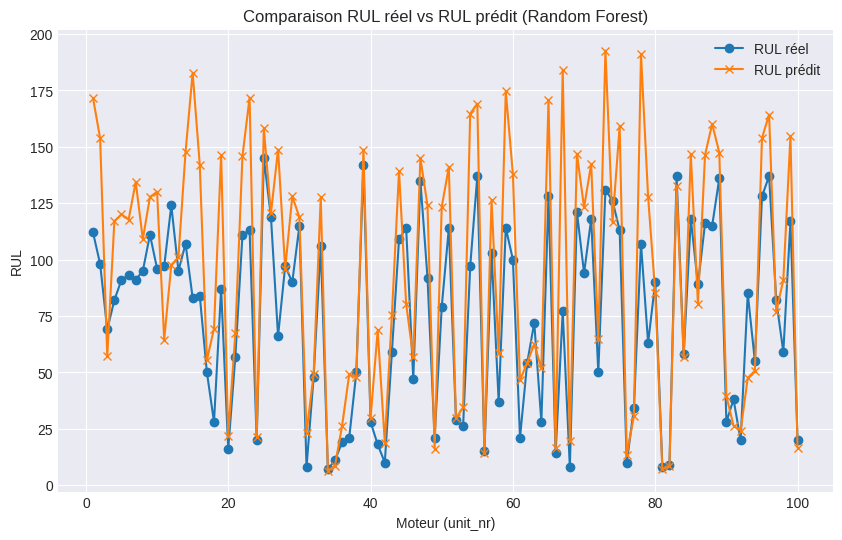

In [85]:
plt.figure(figsize=(10,6))

plt.plot(error_df["unit_nr"], error_df["RUL_réel"],
         label="RUL réel", marker="o")

plt.plot(error_df["unit_nr"], error_df["RUL_prédit"],
         label="RUL prédit", marker="x")

plt.xlabel("Moteur (unit_nr)")
plt.ylabel("RUL")
plt.title("Comparaison RUL réel vs RUL prédit (Random Forest)")
plt.legend()
plt.grid(True)

plt.show()

## ✅ Conclusion de la Phase 4 : Évaluation

Après l’évaluation sur le jeu de test (`test_FD001.txt`), on peut retenir :  

- Le **modèle Random Forest** présente une **erreur moyenne (RMSE) beaucoup plus faible** que la régression linéaire.  
- Cela confirme que la dégradation d’un moteur est un **processus complexe et non linéaire**, difficile à modéliser par une simple régression linéaire.  
- La régression linéaire reste utile comme **baseline de référence**, mais elle sous-estime la complexité des données.  
- Les graphes de prédiction montrent que le modèle Random Forest suit **très bien la tendance réelle** de RUL pour chaque moteur.  

**Conclusion :** Pour ce problème de maintenance prédictive, **Random Forest est le modèle le plus performant** parmi ceux testés.


##  Conclusion générale du projet

Ce projet avait pour objectif de développer un **système de maintenance prédictive pour turboréacteurs** à partir de données de capteurs et de modèles d’IA.

### Points clés :

1. **Préparation des données** :  
   - Nettoyage et sélection des capteurs pertinents.  
   - Normalisation pour rendre les variables comparables.  

2. **Modélisation** :  
   - Régression linéaire comme baseline.  
   - Random Forest pour capturer les relations **non linéaires**.  

3. **Évaluation** :  
   - Utilisation du dernier cycle de chaque moteur sur le jeu de test.  
   - Calcul de RMSE, MAE et R² pour mesurer la performance.  

4. **Résultats** :  
   - Random Forest est le modèle le plus précis pour prédire le RUL.  
   - Cette méthode permet d’anticiper la défaillance des moteurs et de planifier la maintenance de manière optimale.  

### Impact pratique :

- Optimisation de la maintenance et réduction des coûts.  
- Augmentation de la **sécurité aéronautique**.  
- Méthodologie applicable à d’autres systèmes industriels complexes nécessitant une maintenance prédictive.